In [85]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from registration_utilities import *
from annotation_utilities import *
from metadata import *
from data_manager import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
stack_fixed = 'MD642'
stack_moving = 'atlasV3'
classifier_setting = 37

In [3]:
volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
DataManager.load_original_volume_all_known_structures(stack=stack_fixed, classifier_setting=classifier_setting, 
                                                   sided=False, volume_type='score')

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.


rm -rf /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_outerContour.bp && mkdir -p /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_outerContour.bp /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_outerContour.bp


Child returned 0
Child returned 1
0.36 seconds.
File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_outerContour.bp
Score volume for outerContour does not exist.
Child returned 0


rm -rf /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_sp5.bp && mkdir -p /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_sp5.bp /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_sp5.bp


Child returned 1
0.35 seconds.
File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_sp5.bp
Score volume for sp5 does not exist.
Volume shape: (487, 897, 388)


In [4]:
gradient_filepath_map_f = {ind_f: \
                           DataManager.get_volume_gradient_filepath_template(\
                            stack=stack_fixed, structure=struct_f, classifier_setting=classifier_setting)
                           for ind_f, struct_f in label_to_structure_fixed.iteritems()}

In [91]:
registration_settings = read_csv(REGISTRATION_SETTINGS_CSV, header=0, index_col=0)

In [92]:
registration_settings

upstream_warp_id transform_type  terminate_thresh  \
warp_id                                                     
1                   None         affine          0.000010   
2                      1          rigid          0.000010   
4                      1          rigid          0.000001   
5                      1          rigid          0.000001   
6                      1         affine          0.000010   
7                   None          rigid          0.000001   
8                      1          rigid          0.000001   
10                  None          rigid          0.000010   
11                     1         affine          0.000010   

         grad_computation_sample_number  grid_search_sample_number  std_tx_um  \
warp_id                                                                         
1                              100000.0                     1000.0       2000   
2                              100000.0                    10000.0        100   
4                              100000.0                    10000.0        100   
5                              100000.0                    10000.0        100   
6                              100000.0                    10000.0        100   
7                              100000.0                     1000.0         50   
8                              100000.0                    10000.0        200   
10                             100000.0                     1000.0        100   
11                             100000.0                    10000.0        100   

         std_ty_um  std_tz_um  std_theta_xy_degree surround_weight  \
warp_id                                                              
1             2000       2000                   30               0   
2              100        100                   30               0   
4              100        100                   10               0   
5              100        100                   30         inverse   
6              100        100                   30            -0.5   
7               50         50                   10               0   
8              200        200                   30         inverse   
10             100        100                   30               0   
11             100        100                   30            -0.1   

         regularization_weight  
warp_id                         
1                          NaN  
2                          NaN  
4                     0.000001  
5                     0.000000  
6                     0.000000  
7                          NaN  
8                     0.000000  
10                         NaN  
11                    0.000000

In [93]:
warp_setting = 8

In [94]:
warp_properties = registration_settings.loc[warp_setting]
print warp_properties

upstream_warp_setting = warp_properties['upstream_warp_id']
if upstream_warp_setting == 'None':
    upstream_warp_setting = None
else:
    upstream_warp_setting = int(upstream_warp_setting)
    
transform_type = warp_properties['transform_type']
terminate_thresh = warp_properties['terminate_thresh']
grad_computation_sample_number = warp_properties['grad_computation_sample_number']
grid_search_sample_number = warp_properties['grid_search_sample_number']
std_tx_um = warp_properties['std_tx_um']
std_ty_um = warp_properties['std_ty_um']
std_tz_um = warp_properties['std_tz_um']
std_tx = std_tx_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_ty = std_ty_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_tz = std_tz_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_theta_xy = np.deg2rad(warp_properties['std_theta_xy_degree'])
print std_tx, std_ty, std_tz, std_theta_xy

reg_weight = warp_properties['regularization_weight']
reg_weights = np.ones((3,))*reg_weight

surround_weight = warp_properties['surround_weight']
# surround_weight = -.5
include_surround = surround_weight != 0

upstream_warp_id                        1
transform_type                      rigid
terminate_thresh                    1e-06
grad_computation_sample_number     100000
grid_search_sample_number           10000
std_tx_um                             200
std_ty_um                             200
std_tz_um                             200
std_theta_xy_degree                    30
surround_weight                   inverse
regularization_weight                   0
Name: 8, dtype: object
13.5869565217 13.5869565217 13.5869565217 0.523598775598


In [95]:
MAX_ITER_NUM = 1000
HISTORY_LEN = 50
MAX_GRID_SEARCH_ITER_NUM = 30

In [96]:
lr1 = 10
lr2 = 0.1

# General Align Code

In [97]:
trial_num = 1

In [98]:
# for structure in all_known_structures_sided:
for structure in ['AP']:
# for structure in ['SNC_R']:

    try:
        if include_surround:
            volume_moving = DataManager.load_transformed_volume_all_known_structures(stack_m=stack_moving, stack_f=stack_fixed,
                                                                         classifier_setting_m=classifier_setting,
                                                                         classifier_setting_f=classifier_setting,
                                                                         warp_setting=upstream_warp_setting, 
                                                                         structures=[structure, 
                                                                                     convert_to_surround_name(structure, margin='200')])
        else:
            volume_moving = DataManager.load_transformed_volume_all_known_structures(stack_m=stack_moving, stack_f=stack_fixed,
                                                                         classifier_setting_m=classifier_setting,
                                                                         classifier_setting_f=classifier_setting,
                                                                         warp_setting=upstream_warp_setting, 
                                                                         structures=[structure])

        structure_to_label_moving = {s: l+1 for l, s in enumerate(sorted(volume_moving.keys()))}
        label_to_structure_moving = {l+1: s for l, s in enumerate(sorted(volume_moving.keys()))}
        volume_moving = {structure_to_label_moving[s]: v for s, v in volume_moving.items()}

        volume_moving_structure_sizes = {l: np.count_nonzero(vol > 0) for l, vol in volume_moving.iteritems()}

        label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
                             for label_m, name_m in label_to_structure_moving.iteritems()}

        if surround_weight == 'inverse':
            label_weights_m = {label_m: -volume_moving_structure_sizes[structure_to_label_moving[convert_to_nonsurround_name(name_m)]]
                               /float(volume_moving_structure_sizes[label_m])
                               if is_surround_label(name_m) else 1. \
                               for label_m, name_m in label_to_structure_moving.iteritems()}
        elif isinstace(surround_weight, int) or isinstace(surround_weight, float):
            label_weights_m = {label_m: surround_weight if is_surround_label(name_m) else 1. \
                               for label_m, name_m in label_to_structure_moving.iteritems()}
        else:
            sys.stderr.write("surround_weight %s is not recognized. Using the default.\n" % surround_weight)
            

        aligner = Aligner4(volume_fixed, volume_moving, 
                           labelIndexMap_m2f=label_mapping_m2f)

        aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', 
                             indices_m=[structure_to_label_moving[structure]])                            

        aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f) # 120s = 2 mins

        aligner.set_regularization_weights(reg_weights)
        aligner.set_label_weights(label_weights_m)
        
        T_all_trials = []
        scores_all_trials = []

        for trial_idx in range(trial_num):

            T, scores = aligner.optimize(type=transform_type, 
                                         max_iter_num=MAX_ITER_NUM, 
                                         history_len=HISTORY_LEN, 
                                         terminate_thresh=terminate_thresh,
                                         grid_search_iteration_number=MAX_GRID_SEARCH_ITER_NUM,
                                         grid_search_sample_number=grid_search_sample_number,
                                         grad_computation_sample_number=grad_computation_sample_number,
                                         lr1=lr1, lr2=lr2,
                                        std_tx=std_tx, std_ty=std_ty, std_tz=std_tz, std_theta_xy=std_theta_xy)

    #         print T.reshape((3,4))
    #         plt.figure();
    #         plt.plot(scores);
    #         plt.show();
    #         print max(scores), scores[-1]

            T_all_trials.append(T)
            scores_all_trials.append(scores)

#             params_fp = \
#             DataManager.get_alignment_parameters_filepath(stack_m=stack_moving, stack_f=stack_fixed,
#                                                           classifier_setting_m=classifier_setting,
#                                                           classifier_setting_f=classifier_setting,
#                                                           warp_setting=warp_setting,
#                                                           param_suffix=structure,
#                                                           trial_idx=trial_idx)
#             create_parent_dir_if_not_exists(params_fp)
#             DataManager.save_alignment_parameters(params_fp, T, 
#                                                   aligner.centroid_m, aligner.centroid_f,
#                                                   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#                                                   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

            
#             history_fp = DataManager.get_score_history_filepath(stack_m=stack_moving, stack_f=stack_fixed,
#                                                           classifier_setting_m=classifier_setting,
#                                                           classifier_setting_f=classifier_setting,
#                                                           warp_setting=warp_setting,
#                                                           param_suffix=structure,
#                                                           trial_idx=trial_idx)
#             bp.pack_ndarray_file(np.array(scores), history_fp)
            
#             score_plot_fp = \
#             DataManager.get_alignment_score_plot_filepath(stack_m=stack_moving, stack_f=stack_fixed,
#                                                           classifier_setting_m=classifier_setting,
#                                                           classifier_setting_f=classifier_setting,
#                                                           warp_setting=warp_setting,
#                                                           param_suffix=structure,
#                                                           trial_idx=trial_idx)
#             fig = plt.figure();
#             plt.plot(scores);
#             plt.savefig(score_plot_fp, bbox_inches='tight')
#             plt.close(fig)

#             upload_from_ec2_to_s3(history_fp)
#             upload_from_ec2_to_s3(params_fp)
#             upload_from_ec2_to_s3(score_plot_fp)

    except Exception as e:
        sys.stderr.write('%s\n' % e)
        sys.stderr.write('Error transforming volume %s.\n' % structure)

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


m: [ 456.3097856   240.18865677  193.64412681] f: [ 456.3097856   240.18865677  193.64412681]
set([9])


load gradient 9: 11.931282 seconds
overall: 11.931388 seconds
grid search: 7.887403 seconds
tx_best: -11.57 (voxel), ty_best: -13.38, tz_best: -7.13, theta_xy_best: 28.24 (deg)
sigma_tx: 13.59 (voxel), sigma_ty: 13.59, sigma_tz: 13.59, sigma_theta_xy: 30.00 (deg)
-inf 0.002802
grid search: 5.566698 seconds
tx_best: -11.60 (voxel), ty_best: -21.84, tz_best: -6.23, theta_xy_best: 7.59 (deg)
sigma_tx: 9.74 (voxel), sigma_ty: 9.74, sigma_tz: 9.74, sigma_theta_xy: 21.50 (deg)
0.002802 0.004332
iteration 0
step: 0.04 seconds
score: 0.004332
iteration 1
step: 0.04 seconds
score: 0.004596
iteration 2
step: 0.04 seconds
score: 0.004729
iteration 3
step: 0.04 seconds
score: 0.004821
iteration 4
step: 0.04 seconds
score: 0.004629
iteration 5


params_best_upToNow [-11.60207458 -21.84081145  -6.23182145   0.13250792]


step: 0.04 seconds
score: 0.003572
iteration 6
step: 0.04 seconds
score: 0.004330
iteration 7
step: 0.04 seconds
score: 0.004281
iteration 8
step: 0.04 seconds
score: 0.004716
iteration 9
step: 0.04 seconds
score: 0.004698
iteration 10
step: 0.04 seconds
score: 0.004784
iteration 11
step: 0.04 seconds
score: 0.004786
iteration 12
step: 0.04 seconds
score: 0.004864
iteration 13
step: 0.04 seconds
score: 0.004840
iteration 14
step: 0.04 seconds
score: 0.004893
iteration 15
step: 0.04 seconds
score: 0.004896
iteration 16
step: 0.04 seconds
score: 0.004921
iteration 17
step: 0.04 seconds
score: 0.004930
iteration 18
step: 0.04 seconds
score: 0.004948
iteration 19
step: 0.04 seconds
score: 0.004951
iteration 20
step: 0.04 seconds
score: 0.004958
iteration 21
step: 0.04 seconds
score: 0.004972
iteration 22
step: 0.04 seconds
score: 0.004958
iteration 23
step: 0.04 seconds
score: 0.004969
iteration 24
step: 0.04 seconds
score: 0.004969
iteration 25
step: 0.04 seconds
score: 0.004977
iteration

step: 0.04 seconds
score: 0.005097
iteration 180
step: 0.04 seconds
score: 0.005103
iteration 181
step: 0.04 seconds
score: 0.005110
iteration 182
step: 0.04 seconds
score: 0.005101
iteration 183
step: 0.04 seconds
score: 0.005110
iteration 184
step: 0.04 seconds
score: 0.005098
iteration 185
step: 0.04 seconds
score: 0.005109
iteration 186
step: 0.04 seconds
score: 0.005100
iteration 187
step: 0.04 seconds
score: 0.005112
iteration 188
step: 0.04 seconds
score: 0.005093
iteration 189
step: 0.04 seconds
score: 0.005105
iteration 190
step: 0.04 seconds
score: 0.005097
iteration 191
step: 0.04 seconds
score: 0.005099
iteration 192
step: 0.04 seconds
score: 0.005107
iteration 193
step: 0.04 seconds
score: 0.005094
iteration 194
step: 0.04 seconds
score: 0.005096
iteration 195
step: 0.04 seconds
score: 0.005096
iteration 196
step: 0.04 seconds
score: 0.005101
iteration 197
step: 0.04 seconds
score: 0.005090
iteration 198
step: 0.04 seconds
score: 0.005101
iteration 199
step: 0.04 seconds
s

step: 0.04 seconds
score: 0.005170
iteration 348
step: 0.04 seconds
score: 0.005172
iteration 349
step: 0.04 seconds
score: 0.005171
iteration 350
step: 0.04 seconds
score: 0.005168
iteration 351
step: 0.04 seconds
score: 0.005165
iteration 352
step: 0.04 seconds
score: 0.005167
iteration 353
step: 0.04 seconds
score: 0.005168
iteration 354
step: 0.04 seconds
score: 0.005165
iteration 355
step: 0.04 seconds
score: 0.005164
iteration 356
step: 0.04 seconds
score: 0.005167
iteration 357
step: 0.04 seconds
score: 0.005160
iteration 358
step: 0.04 seconds
score: 0.005162
iteration 359
step: 0.04 seconds
score: 0.005164
iteration 360
step: 0.04 seconds
score: 0.005162
iteration 361
step: 0.04 seconds
score: 0.005163
iteration 362
step: 0.04 seconds
score: 0.005166
iteration 363
step: 0.04 seconds
score: 0.005166
iteration 364
step: 0.04 seconds
score: 0.005167
iteration 365
step: 0.04 seconds
score: 0.005170
iteration 366
step: 0.04 seconds
score: 0.005167
iteration 367
step: 0.04 seconds
s

step: 0.04 seconds
score: 0.005229
iteration 516
step: 0.04 seconds
score: 0.005221
iteration 517
step: 0.04 seconds
score: 0.005232
iteration 518
step: 0.04 seconds
score: 0.005207
iteration 519
step: 0.04 seconds
score: 0.005231
iteration 520
step: 0.04 seconds
score: 0.005197
iteration 521
step: 0.04 seconds
score: 0.005211
iteration 522
step: 0.04 seconds
score: 0.005215
iteration 523
step: 0.04 seconds
score: 0.005216
iteration 524
step: 0.04 seconds
score: 0.005216
iteration 525
step: 0.04 seconds
score: 0.005228
iteration 526
step: 0.04 seconds
score: 0.005201
iteration 527
step: 0.04 seconds
score: 0.005205
iteration 528
step: 0.04 seconds
score: 0.005215
iteration 529
step: 0.04 seconds
score: 0.005201
iteration 530
step: 0.04 seconds
score: 0.005221
iteration 531
step: 0.04 seconds
score: 0.005204
iteration 532
step: 0.04 seconds
score: 0.005218
iteration 533
step: 0.04 seconds
score: 0.005201
iteration 534
step: 0.04 seconds
score: 0.005203
iteration 535
step: 0.04 seconds
s

step: 0.04 seconds
score: 0.005253
iteration 684
step: 0.04 seconds
score: 0.005251
iteration 685
step: 0.04 seconds
score: 0.005260
iteration 686
step: 0.04 seconds
score: 0.005260
iteration 687
step: 0.04 seconds
score: 0.005247
iteration 688
step: 0.04 seconds
score: 0.005252
iteration 689
step: 0.04 seconds
score: 0.005257
iteration 690
step: 0.04 seconds
score: 0.005254
iteration 691
step: 0.04 seconds
score: 0.005251
iteration 692
step: 0.04 seconds
score: 0.005256
iteration 693
step: 0.04 seconds
score: 0.005254
iteration 694
step: 0.04 seconds
score: 0.005258
iteration 695
step: 0.04 seconds
score: 0.005252
iteration 696
step: 0.04 seconds
score: 0.005257
iteration 697
step: 0.04 seconds
score: 0.005255
iteration 698
step: 0.04 seconds
score: 0.005256
iteration 699
step: 0.04 seconds
score: 0.005258
iteration 700
step: 0.04 seconds
score: 0.005252
iteration 701
step: 0.04 seconds
score: 0.005253
iteration 702
step: 0.04 seconds
score: 0.005254
iteration 703
step: 0.04 seconds
s

step: 0.04 seconds
score: 0.005290
iteration 852
step: 0.04 seconds
score: 0.005293
iteration 853
step: 0.04 seconds
score: 0.005289
iteration 854
step: 0.04 seconds
score: 0.005291
iteration 855
step: 0.04 seconds
score: 0.005286
iteration 856
step: 0.04 seconds
score: 0.005297
iteration 857
step: 0.04 seconds
score: 0.005286
iteration 858
step: 0.04 seconds
score: 0.005294
iteration 859
step: 0.04 seconds
score: 0.005285
iteration 860
step: 0.04 seconds
score: 0.005294
iteration 861
step: 0.04 seconds
score: 0.005280
iteration 862
step: 0.04 seconds
score: 0.005300
iteration 863
step: 0.04 seconds
score: 0.005286
iteration 864
step: 0.04 seconds
score: 0.005296
iteration 865
step: 0.04 seconds
score: 0.005284
iteration 866
step: 0.04 seconds
score: 0.005295
iteration 867
step: 0.04 seconds
score: 0.005285
iteration 868
step: 0.04 seconds
score: 0.005301
iteration 869
step: 0.04 seconds
score: 0.005299
iteration 870
step: 0.04 seconds
score: 0.005298
iteration 871
step: 0.04 seconds
s

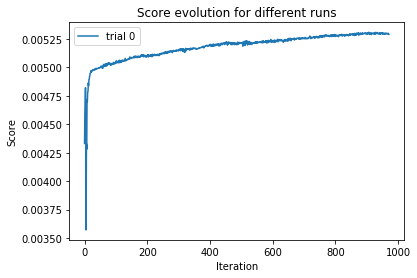

In [99]:
plt.figure();
for trial_idx, scores in enumerate(scores_all_trials):
    plt.plot(scores, label='trial ' + str(trial_idx));
plt.xlabel('Iteration');
plt.ylabel('Score');
plt.legend();
plt.title('Score evolution for different runs');

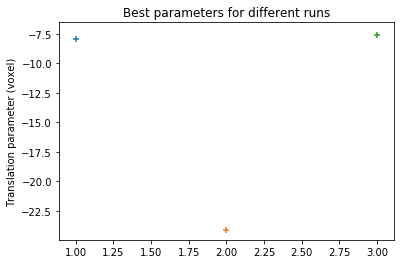

In [100]:
T_all_trials = np.array(T_all_trials)
plt.scatter(np.ones((T_all_trials.shape[0],)), T_all_trials[:, 3], marker='+');
plt.scatter(2*np.ones((T_all_trials.shape[0],)), T_all_trials[:, 7], marker='+');
plt.scatter(3*np.ones((T_all_trials.shape[0],)), T_all_trials[:, 11], marker='+');
plt.ylabel('Translation parameter (voxel)');
plt.title('Best parameters for different runs');

Best trial: 0
[[  7.99329723e-01   9.07304106e-02   5.94003355e-01  -7.95842337e+00]
 [  5.83979231e-03   9.87315234e-01  -1.58664821e-01  -2.41134438e+01]
 [ -6.00864286e-01   1.30294364e-01   7.88660566e-01  -7.62482903e+00]]


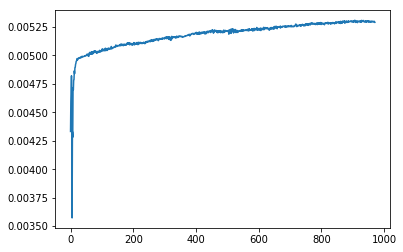

0.00530883401438 0.0052907755333


In [101]:
best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]
# best_trial = 0
T = T_all_trials[best_trial]
scores = scores_all_trials[best_trial]
print 'Best trial:', best_trial
print T.reshape((3,4))
plt.figure();
plt.plot(scores);
plt.show();
print max(scores), scores[-1]

# Draw Results

In [102]:
t = time.time()

# local_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# DataManager.load_alignment_parameters(stack_m=stack_moving, stack_f=stack_fixed,
#                                       classifier_setting_m=classifier_setting,
#                                       classifier_setting_f=classifier_setting,
#                                       warp_setting=warp_setting,
#                                       param_suffix=structure,
#                                       trial_idx=trial_idx)

local_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
(T, 
  aligner.centroid_m, aligner.centroid_f,
  aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
  aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

# local_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# ([1,0,0,0,0,1,0,0,0,0,1,0], 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)


# Read global tx
global_transformed_moving_structure_vol = \
DataManager.load_transformed_volume(stack_m=stack_moving, stack_f=stack_fixed,
                                    classifier_setting_m=classifier_setting,
                                    classifier_setting_f=classifier_setting,
                                    warp_setting=upstream_warp_setting, 
                                    structure=structure)

# Transform
local_transformed_moving_structure_vol = transform_volume(vol=global_transformed_moving_structure_vol, 
                                         global_params=local_params, 
                                         centroid_m=centroid_m, centroid_f=centroid_f,
                                         xdim_f=xdim_f, ydim_f=ydim_f, zdim_f=zdim_f)

#         # Save
#         local_transformed_moving_structure_fn = \
#         DataManager.get_transformed_volume_filepath(stack_m=stack_moving, stack_f=stack_fixed,
#                                                     classifier_setting_m=classifier_setting,
#                                                     classifier_setting_f=classifier_setting,
#                                                     warp_setting=warp_setting,
#                                                     trial_idx=trial_idx,
#                                                     structure=structure)

#         create_if_not_exists(os.path.dirname(local_transformed_moving_structure_fn))
#         bp.pack_ndarray_file(local_transformed_moving_structure_vol, local_transformed_moving_structure_fn)

sys.stderr.write('Transform: %.2f seconds.\n' % (time.time() - t))

Transform: 3.96 seconds.


In [103]:
# Set colors for different contour level
levels = [0.1, 0.25, 0.5, 0.75, .99]
# levels = [0.5]
level_colors = {level: (int(level*255),0,0) for level in levels}

0 896 0 486 108 495


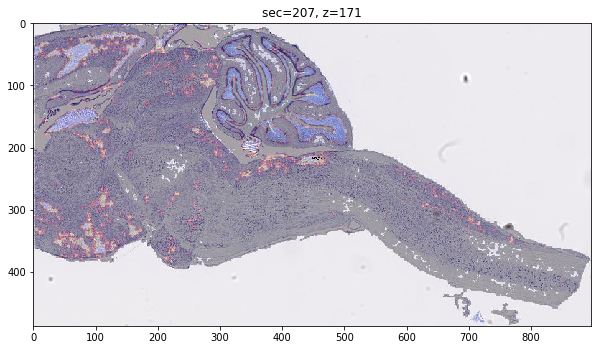

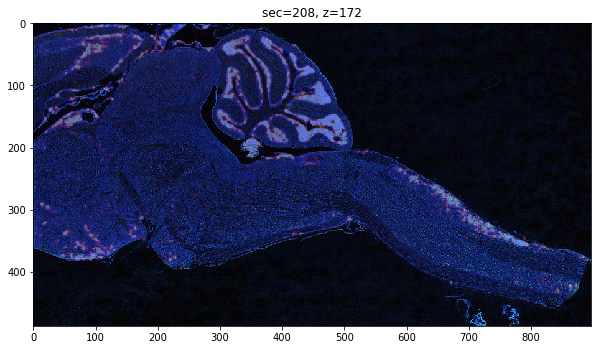

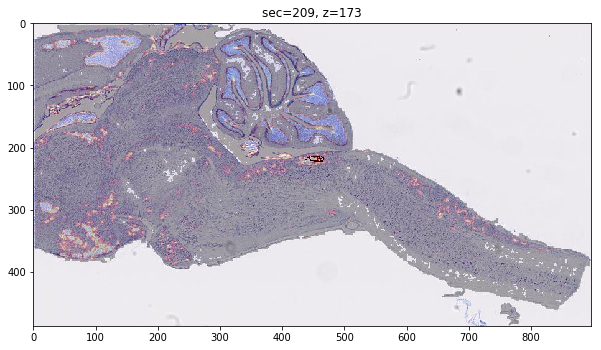

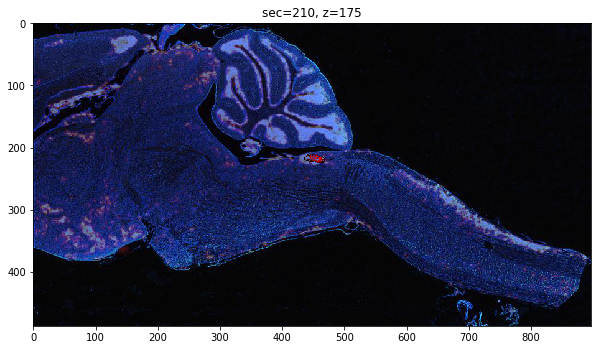

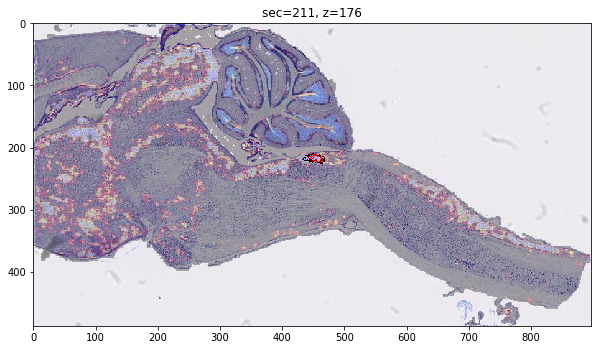

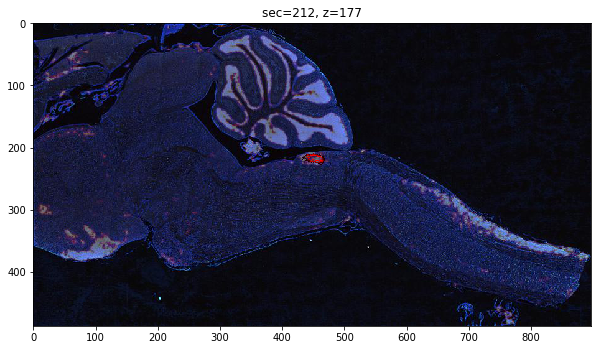

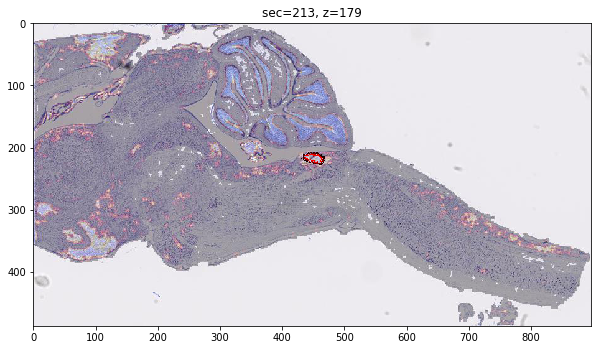

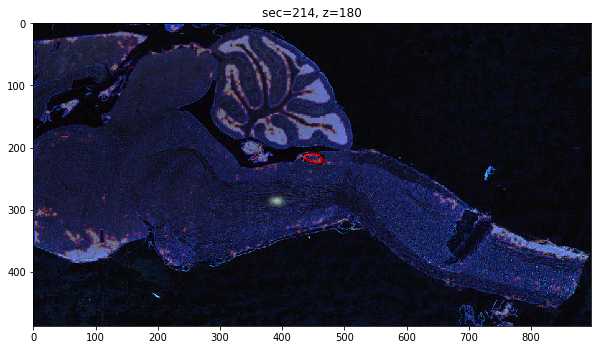

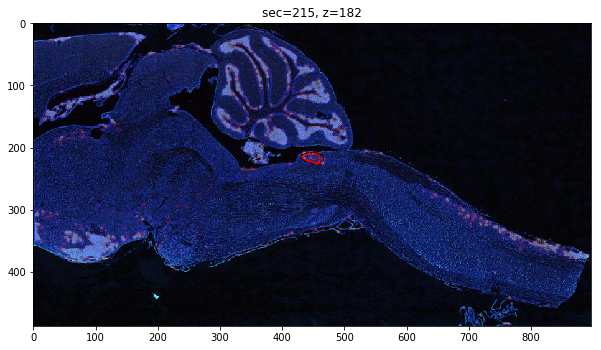

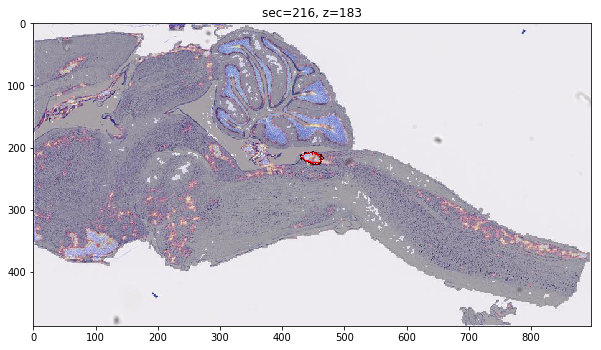

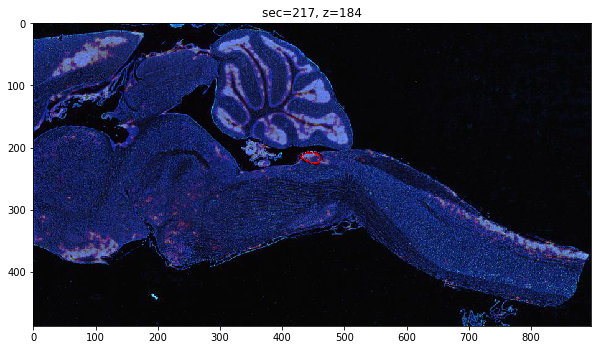

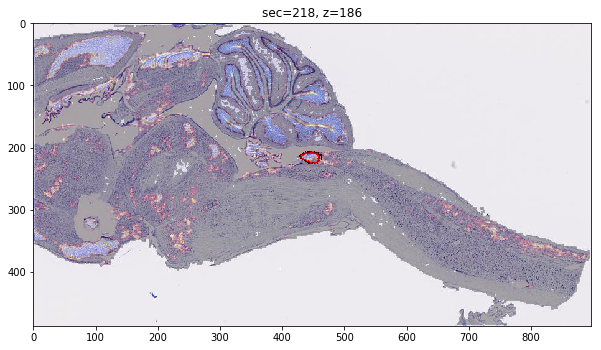

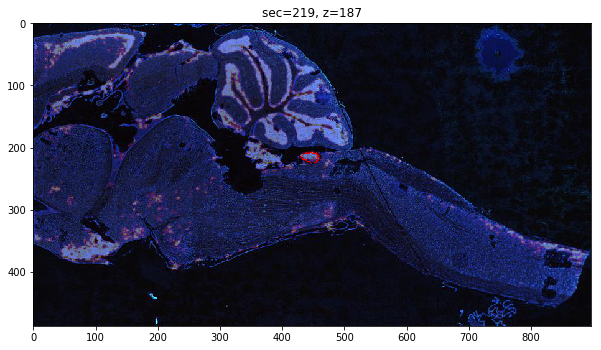

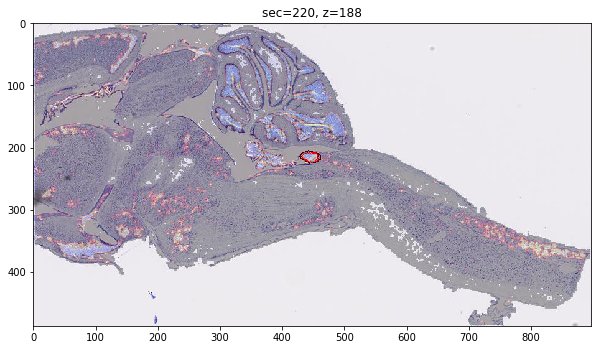

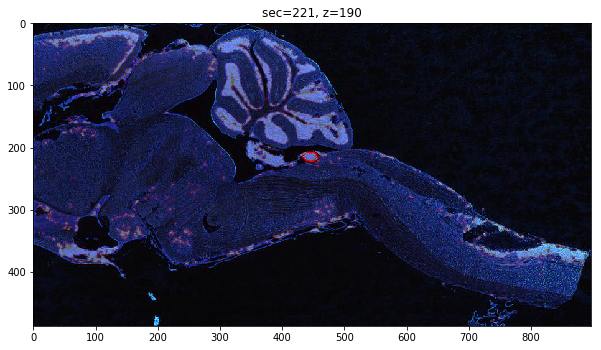

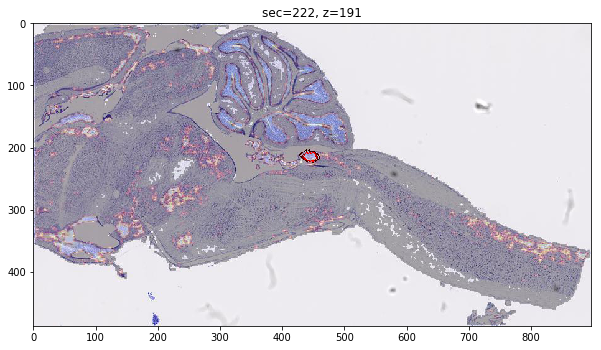

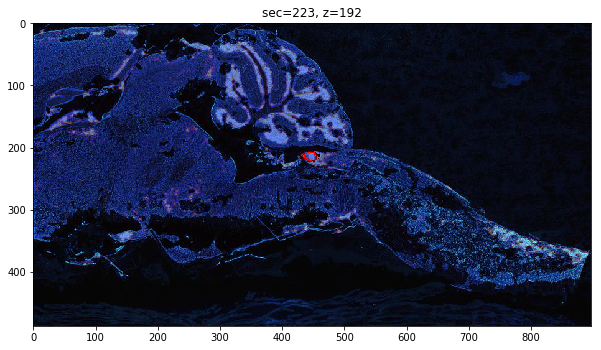

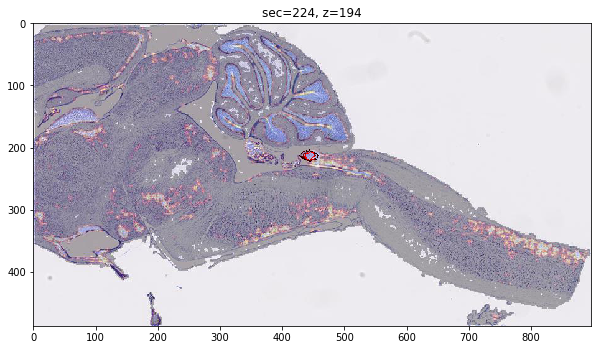

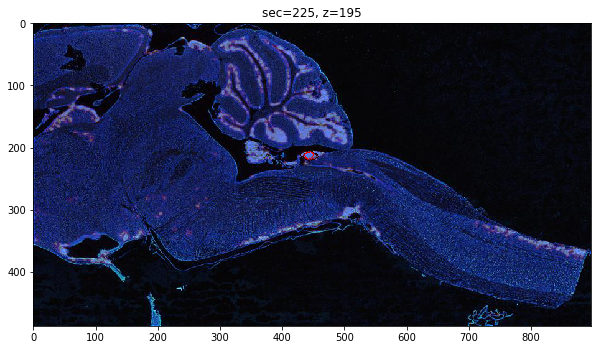

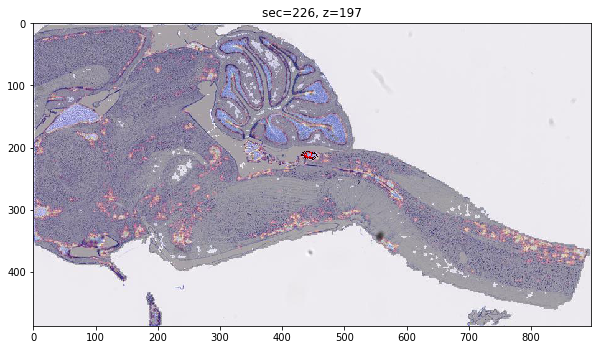

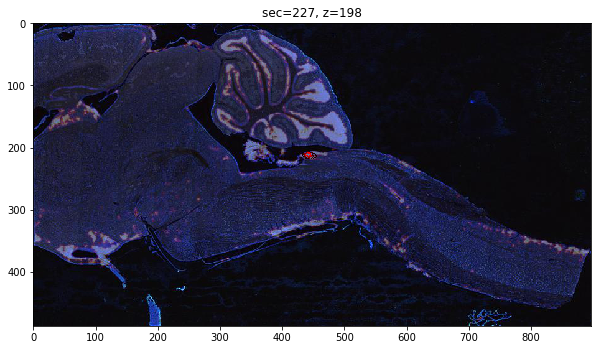

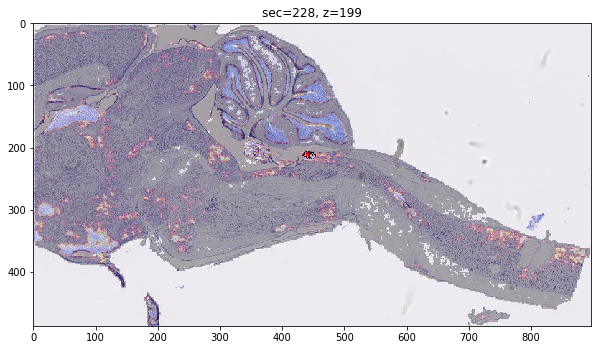

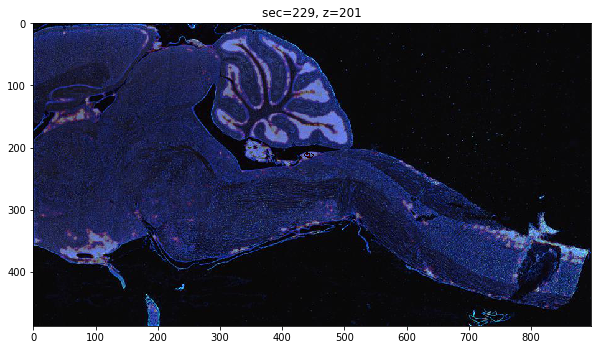

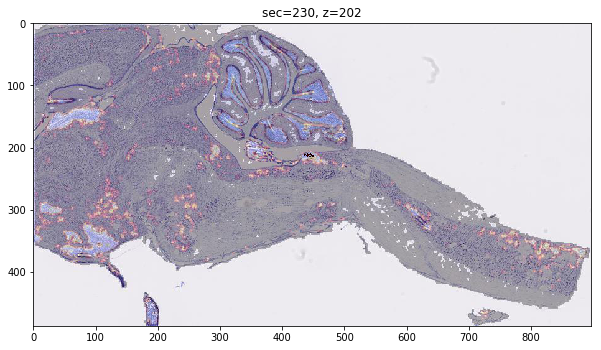

In [104]:
# Generate overlay visualization

# estimate mapping between z and section
# downsample_factor = 32
# xy_pixel_distance_downsampled = XY_PIXEL_DISTANCE_LOSSLESS * downsample_factor
# voxel_z_size = SECTION_THICKNESS / xy_pixel_distance_downsampled

# For getting correct contour location
xmin_vol_f, xmax_vol_f, ymin_vol_f, ymax_vol_f, zmin_vol_f, zmax_vol_f = \
DataManager.load_original_volume_bbox(stack=stack_fixed, vol_type='score', structure='7N', 
                             downscale=32, classifier_setting=classifier_setting)
print xmin_vol_f, xmax_vol_f, ymin_vol_f, ymax_vol_f, zmin_vol_f, zmax_vol_f

# Generate atlas overlay image for every section

zf, zl = bbox_3d(local_transformed_moving_structure_vol)[4:]
sec_first = DataManager.convert_z_to_section(stack=stack_fixed, z=zf, downsample=32)
sec_last = DataManager.convert_z_to_section(stack=stack_fixed, z=zl, downsample=32)

for sec in range(sec_first, sec_last+1):
# for sec in [181]:
    
    if is_invalid(stack=stack_fixed, sec=sec):
        continue
    
#     img_fn = DataManager.get_image_filepath(stack=stack_fixed, section=sec, resol='thumbnail', version='cropped_tif')
#     img = imread(img_fn)
    
    try:
        fp = DataManager.get_scoremap_viz_filepath(stack=stack_fixed, downscale=32, section=sec, 
                                                           structure=convert_to_original_name(structure), 
                                                           classifier_id=classifier_setting)
        download_from_s3(fp)
        img = imread(fp)
    except Exception as e:
        sys.stderr.write('Error loading scoremap for section %d: %s\n' % (sec, e))
        continue
        
#     img = img[::4, ::4]
    
    viz = img.copy()
    
    z1, z2 = DataManager.convert_section_to_z(stack=stack_fixed, sec=sec, downsample=32)
    z = int(z1)
    
    # Find moving volume annotation contours
    c = 0
    vol = local_transformed_moving_structure_vol
    for level in levels:
        cnts = find_contours(vol[..., z], level=level) # rows, cols
        c += len(cnts)
        for cnt in cnts:
            # r,c to x,y
            cnt_on_cropped = cnt[:,::-1] + (xmin_vol_f, ymin_vol_f)
            cv2.polylines(viz, [cnt_on_cropped.astype(np.int)], True, level_colors[level], 1)
    
    if c > 0:    
        plt.figure(figsize=(10,10));
        plt.title("sec=%d, z=%d" % (sec, z));
        plt.imshow(viz);
        plt.show();
    
#     viz_fp = DataManager.get_alignment_viz_filepath(stack_m=stack_moving,
#                                             stack_f=stack_fixed,
#                                             classifier_setting_m=classifier_setting,
#                                             classifier_setting_f=classifier_setting,
#                                             warp_setting=warp_setting,
#                                           section=sec)
    
#     create_if_not_exists(os.path.dirname(viz_fp))
#     imsave(viz_fp, viz)

In [154]:
display_image(viz)

/oasis/projects/nsf/csd395/yuncong/Brain/registration/tmp.jpg